In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree, linear_model

In [0]:
# Function that generates the dataset
f = lambda x: eval('-3.5 * np.log10(np.abs(5*x)) * np.sin(5*x) * np.cos(5*x)')

In [0]:
# Generate n real samples from defined function
def generate_real_samples(n):
    # From random points generate y [x in -1:+1]
	x = 2 * (np.random.rand(n) - 0.5)
	y = f(x)
    
	# Stack arrays as matrix (n, 2)
	x = x.reshape(n, 1)
	y = y.reshape(n, 1)
	datapoints = np.hstack((x, y))
    
	# Generate class labels (real = 1 / fake = 0)
	labels = np.ones((n, 1))
    
    # Return datapoints and corresponding labels
	return datapoints, labels

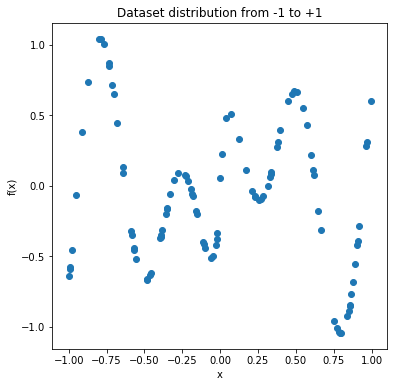

In [4]:
# Create N random datapoints
N = 100
datapoints = generate_real_samples(N)[0]
x, y = np.hsplit(datapoints, 2)

plt.figure(figsize=(6, 6))
plt.scatter(x, f(x))
plt.title('Dataset distribution from -1 to +1')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

In [5]:
from keras.models import Sequential
from keras.layers import Dense
 
# Define the standalone discriminator model
def define_discriminator(n_inputs=2):
	model = Sequential()
	model.add(Dense(50, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

 
# Define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
	model = Sequential()
	model.add(Dense(50, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(n_outputs, activation='linear'))
	return model

 
# Define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model


# Evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
    # Prepare real samples
    x_real, y_real = generate_real_samples(n)
    # Evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    
    # Prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # Evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)

    # Scatter plot real and fake data points
    plt.scatter(x_real[:, 0], x_real[:, 1], color='red')
    plt.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    plt.title(f'Epoch: {epoch}  Real_Acc: {acc_real}  Fake_Acc: {acc_fake}')
    plt.show()

Using TensorFlow backend.


In [0]:
# Generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# Generate normal distributed points in the latent space (n x latent_dim)
	x_input = np.random.randn(latent_dim * n).reshape(n, latent_dim)
    
	return x_input

In [0]:
# Generate n fake examples from the generator model
def generate_fake_samples(generator, latent_dim, n):
    # Generate points in latent space
    x_input = generate_latent_points(latent_dim, n)

    # Produce fake datapoints
    fake_datapoints = generator.predict(x_input)

    # Generate class labels (real = 1 / fake = 0)
    labels = np.zeros((n, 1))

    # Return fake datapoints and corresponding labels
    return fake_datapoints, labels

In [0]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

In [0]:
def unison_shuffled_copies(a, b):
    assert a.shape[0] == b.shape[0]
    p = np.random.permutation(a.shape[0])
    return a[p], b[p]

In [0]:
# Train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=2e4, n_batch=256, n_eval=2000):
    # Determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    
    n_epochs = int(n_epochs)
    
    # Manually enumerate epochs
    for i in range(n_epochs):
        ###########################
        ### TRAIN DISCRIMINATOR ###
        ###########################
        for j in range(5):
            # Get real samples
            x_real, y_real = generate_real_samples(half_batch)

            # Produce fake examples using the generator
            x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch - half_batch)

            # Train discriminator
            x_shuff, y_shuff = unison_shuffled_copies(np.append(x_real, x_fake, axis=0), np.append(y_real, y_fake, axis=0))

            d_model.train_on_batch(x_shuff, y_shuff)


        ###########################
        ###   TRAIN GENERATOR   ###
        ###########################
        for k in range(2):
            # Generate points in latent space as inputs for the generator
            x_gan = generate_latent_points(latent_dim, n_batch)

            # Create inverted labels for the fake samples (real = 1 / fake = 0)
            y_gan = np.ones((n_batch, 1))

            # Update the generator via the discriminator's error (discriminator is frozen)
            gan_model.train_on_batch(x_gan, y_gan)


        # Evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            summarize_performance(i+1, g_model, d_model, latent_dim)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where









/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


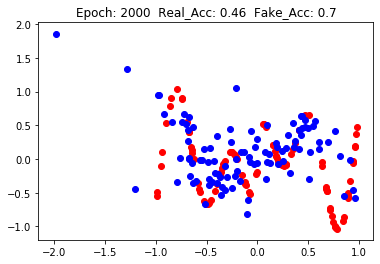

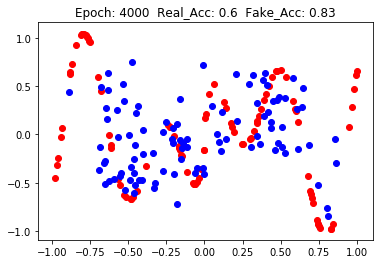

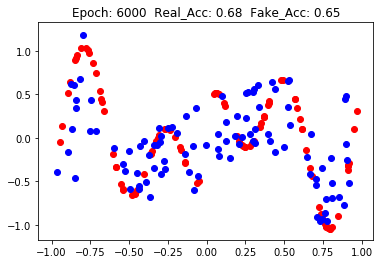

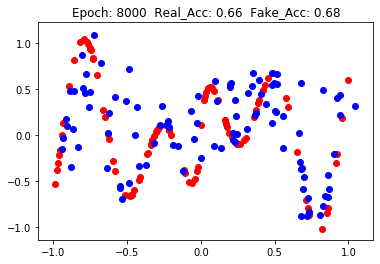

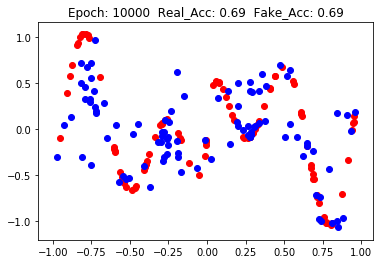

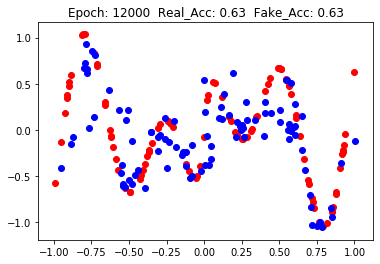

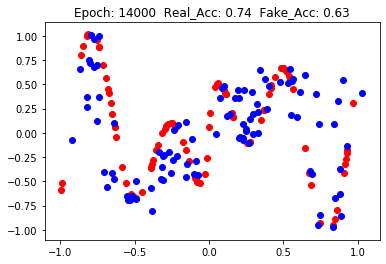

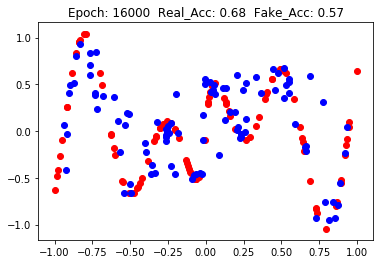

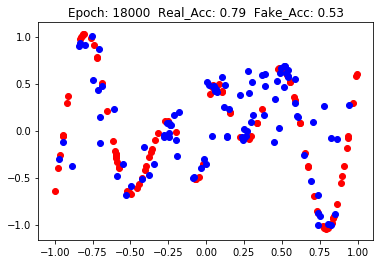

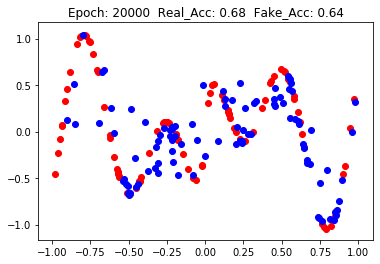

In [11]:
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)